# Dependencias

In [1]:
# PyTorch con Soporte CUDA
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [2]:
# Instalando dependencias
!pip install pyarrow findspark pyspark tensorflow pandas scikit-learn ydata-profiling matplotlib numpy seaborn opencv-python pillow pydicom scikit-image lime tf-keras-vis xlrd googletrans nest_asyncio torch torchvision numpy


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Inicializacion

In [3]:
import sys
from pathlib import Path

# Force add the project root to sys.path (adjust as needed)
project_root = Path("../").resolve()  # one level up from /notebooks/
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

In [4]:
# Calculos
import numpy as np
import pandas as pd

# PyTorch
import torch

# Visualizacion
from ydata_profiling import ProfileReport

# Utilidades
import os
import re

## Constantes

In [5]:
DATA_ABS_PATH                   = os.path.abspath("../data/CBIS-DDSM")
IMAGES_ABS_PATH                 = os.path.abspath("../data/CBIS-DDSM/CBIS-DDSM")
MASS_CASE_DESCRIPTION_TRAIN_SET = DATA_ABS_PATH + '/mass_case_description_train_set.csv'
MASS_CASE_DESCRIPTION_TEST_SET  = DATA_ABS_PATH + '/mass_case_description_test_set.csv'
CALC_CASE_DESCRIPTION_TRAIN_SET = DATA_ABS_PATH + '/calc_case_description_train_set.csv'
CALC_CASE_DESCRIPTION_TEST_SET  = DATA_ABS_PATH + '/calc_case_description_test_set.csv'
METADATA_CSV                    = DATA_ABS_PATH + '/metadata.csv'

CBISDDSM_DF                     = DATA_ABS_PATH + '/meta/CBIS-DDSM.parquet'
CBISDDSM_FIXED_SET              = DATA_ABS_PATH + '/meta/CBIS-DDSM-fixed.parquet'
OUTPUT_TRAIN                    = DATA_ABS_PATH + '/meta/train_split.parquet'
OUTPUT_VAL                      = DATA_ABS_PATH + '/meta/val_split.parquet'
OUTPUT_TEST                     = DATA_ABS_PATH + '/meta/test_split.parquet'

MODELS_OUTPUT_PATH              = os.path.abspath("../models/output/")
MODELS_LOGS_OUTPUT_PATH         = os.path.abspath("../models/logs/")

LABEL_MAP = {
    "BENIGN": 0,
    "BENIGN_WITHOUT_CALLBACK": 1, # Benigno sin necesidad de mas estudios
    "MALIGNANT": 2
}

## Sesion de Spark

In [6]:
import findspark

from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import pyspark.sql.functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, BooleanType


findspark.init()
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark = SparkSession.builder.appName("breast_cancer_detection").master("local[*]").getOrCreate()
sqlCtx = SQLContext(sparkContext=spark.sparkContext, sparkSession=spark)
spark

### Creacion de DataFrames

In [7]:
metadata_df = spark.read.csv(METADATA_CSV, header=True)
metadata_df.describe()

DataFrame[summary: string, Series UID: string, Collection: string, 3rd Party Analysis: string, Data Description URI: string, Subject ID: string, Study UID: string, Study Description: string, Study Date: string, Series Description: string, Manufacturer: string, Modality: string, SOP Class Name: string, SOP Class UID: string, Number of Images: string, File Size: string, File Size float: string, File Location: string, Download Timestamp: string]

In [8]:
mass_train_df = spark.read.csv(MASS_CASE_DESCRIPTION_TRAIN_SET, header=True, inferSchema=True, multiLine=True, quote='"', escape='"')
mass_train_df.describe()

DataFrame[summary: string, patient_id: string, breast_density: string, left or right breast: string, image view: string, abnormality id: string, abnormality type: string, mass shape: string, mass margins: string, assessment: string, pathology: string, subtlety: string, image file path: string, cropped image file path: string, ROI mask file path: string]

In [9]:
mass_test_df = spark.read.csv(MASS_CASE_DESCRIPTION_TEST_SET, header=True, inferSchema=True, multiLine=True, quote='"', escape='"')
mass_test_df.describe()

DataFrame[summary: string, patient_id: string, breast_density: string, left or right breast: string, image view: string, abnormality id: string, abnormality type: string, mass shape: string, mass margins: string, assessment: string, pathology: string, subtlety: string, image file path: string, cropped image file path: string, ROI mask file path: string]

In [10]:
calc_train_df = spark.read.csv(CALC_CASE_DESCRIPTION_TRAIN_SET, header=True, inferSchema=True, multiLine=True, quote='"', escape='"')
calc_train_df.describe()

DataFrame[summary: string, patient_id: string, breast density: string, left or right breast: string, image view: string, abnormality id: string, abnormality type: string, calc type: string, calc distribution: string, assessment: string, pathology: string, subtlety: string, image file path: string, cropped image file path: string, ROI mask file path: string]

In [11]:
calc_test_df = spark.read.csv(CALC_CASE_DESCRIPTION_TEST_SET, header=True, inferSchema=True, multiLine=True, quote='"', escape='"')
calc_test_df.describe()

DataFrame[summary: string, patient_id: string, breast density: string, left or right breast: string, image view: string, abnormality id: string, abnormality type: string, calc type: string, calc distribution: string, assessment: string, pathology: string, subtlety: string, image file path: string, cropped image file path: string, ROI mask file path: string]

**Nota**: Hay algunas columnas que tienen caracteres especiales, como saltos de linea. Como la columna con la direccion del ROI:

In [12]:
calc_test_df.show(2, truncate=False)

+----------+--------------+--------------------+----------+--------------+----------------+--------------------+-----------------+----------+---------+--------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|patient_id|breast density|left or right breast|image view|abnormality id|abnormality type|calc type           |calc distribution|assessment|pathology|subtlety|image file path                                                                                                                                                        |cro

Ahora reemplazare los nombres erroneos de las imagenes (000000.dcm) por su nombre real, segun el siguiente patron:

- **image file path**: Aparece con nombre de archivo 000000.dcm, pero todas se llama 1-1.dcm
- **cropped image file path**: Aparece con nombre de archivo 000000.dcm, pero todas se llaman 1-1.dcm y se encuentran en las carpetas con el sufijo _1 (ejemplo: CC_1, MLO_1, etc.)
- **ROI mak file path**: Aparece con nombre de archivo 000000.dcm, pero todas se llaman 1-2.dcm y se encuentra en las carpetas con el sufijo _1

In [13]:
mass_train_df = mass_train_df \
                .withColumn("image_path", F.regexp_replace("image file path", r"/[^/]+$", "/1-1.dcm")) \
                .withColumn("cropped_path", F.regexp_replace("cropped image file path", r"/[^/]+$", "/1-1.dcm")) \
                .withColumn("roi_path", F.regexp_replace("ROI mask file path", r"/[^/]+$", "/1-1.dcm")) \
                .withColumn("type", F.lit("mass"))

In [14]:
mass_test_df = mass_test_df \
                .withColumn("image_path", F.regexp_replace("image file path", r"/[^/]+$", "/1-1.dcm")) \
                .withColumn("cropped_path", F.regexp_replace("cropped image file path", r"/[^/]+$", "/1-1.dcm")) \
                .withColumn("roi_path", F.regexp_replace("ROI mask file path", r"/[^/]+$", "/1-2.dcm")) \
                .withColumn("type", F.lit("mass"))

In [15]:
calc_train_df = calc_train_df \
                .withColumn("image_path", F.regexp_replace("image file path", r"/[^/]+$", "/1-1.dcm")) \
                .withColumn("cropped_path", F.regexp_replace("cropped image file path", r"/[^/]+$", "/1-1.dcm")) \
                .withColumn("roi_path", F.regexp_replace("ROI mask file path", r"/[^/]+$", "/1-2.dcm")) \
                .withColumn("type", F.lit("calc")) \
                .withColumnRenamed("breast density", "breast_density")

In [16]:
calc_test_df = calc_test_df \
                .withColumn("image_path", F.regexp_replace("image file path", r"/[^/]+$", "/1-1.dcm")) \
                .withColumn("cropped_path", F.regexp_replace("cropped image file path", r"/[^/]+$", "/1-1.dcm")) \
                .withColumn("roi_path", F.regexp_replace("ROI mask file path", r"/[^/]+$", "/1-2.dcm")) \
                .withColumn("type", F.lit("calc")) \
                .withColumnRenamed("breast density", "breast_density")

In [17]:
mass_train_df.filter(F.col('image_path').isNotNull()).count()

1318

In [18]:
mass_train_df.select(F.col('patient_id')).show(5, truncate=False)

+----------+
|patient_id|
+----------+
|P_00001   |
|P_00001   |
|P_00004   |
|P_00004   |
|P_00004   |
+----------+
only showing top 5 rows



In [19]:
print('mass_train_df image_path null count:', mass_train_df.filter(F.col('image_path').isNotNull()).count())
print('mass_train_df cropped_path null count:', mass_train_df.filter(F.col('cropped_path').isNotNull()).count())
print('mass_train_df roi_path null count:', mass_train_df.filter(F.col('roi_path').isNotNull()).count())
print()
print('mass_test_df image_path null count:', mass_test_df.filter(F.col('image_path').isNotNull()).count())
print('mass_test_df cropped_path null count:', mass_test_df.filter(F.col('cropped_path').isNotNull()).count())
print('mass_test_df roi_path null count:', mass_test_df.filter(F.col('roi_path').isNotNull()).count())
print()
print('calc_train_df image_path null count:', calc_train_df.filter(F.col('image_path').isNotNull()).count())
print('calc_train_df cropped_path null count:', calc_train_df.filter(F.col('cropped_path').isNotNull()).count())
print('calc_train_df roi_path null count:', calc_train_df.filter(F.col('roi_path').isNotNull()).count())
print()
print('calc_test_df cropped_path null count:', calc_test_df.filter(F.col('cropped_path').isNotNull()).count())
print('calc_test_df image_path null count:', calc_test_df.filter(F.col('image_path').isNotNull()).count())
print('calc_test_df roi_path null count:', calc_test_df.filter(F.col('roi_path').isNotNull()).count())

mass_train_df image_path null count: 1318
mass_train_df cropped_path null count: 1318
mass_train_df roi_path null count: 1318

mass_test_df image_path null count: 378
mass_test_df cropped_path null count: 378
mass_test_df roi_path null count: 378

calc_train_df image_path null count: 1546
calc_train_df cropped_path null count: 1546
calc_train_df roi_path null count: 1546

calc_test_df cropped_path null count: 326
calc_test_df image_path null count: 326
calc_test_df roi_path null count: 326


In [20]:
mass_train_df.filter(F.col('cropped_path').isNotNull()).count()

1318

In [21]:
mass_train_df.filter(F.col('roi_path').isNotNull()).count()

1318

In [22]:
mass_train_df.select(F.col('roi_path')).show(4, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|roi_path                                                                                                                                                                  |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.108268213011361124203859148071588939106/1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650/1-1.dcm |
|Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.188473874511440575807446266233629582526/1.3.6.1.4.1.9590.100.1.2.227955274711225756835838775062793186053/1-1.dcm|
|Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.414182170112396175925115449620455230167/1.3.6.1.4.1.9590.100.1.2.429120414011

In [23]:
mass_train_df.write.mode("overwrite").parquet(DATA_ABS_PATH + '/meta/mass_train.parquet')
mass_test_df.write.mode("overwrite").parquet(DATA_ABS_PATH + '/meta/mass_test.parquet')
calc_train_df.write.mode("overwrite").parquet(DATA_ABS_PATH + '/meta/calc_train.parquet')
calc_test_df.write.mode("overwrite").parquet(DATA_ABS_PATH + '/meta/calc_test.parquet')

# Creacion de Train y Test datasets

Ahora combinare los datasets de test y de train para tener dos unicos datasets para cada fin, asi el modelo aprende tanto de masas como de calcificaciones y si son benignas o malignas.

In [24]:
train_df = mass_train_df.unionByName(calc_train_df, allowMissingColumns=True)
test_df = mass_test_df.unionByName(calc_test_df,  allowMissingColumns=True)

In [25]:
train_df.count()

2864

In [26]:
train_df.filter(F.col('image_path').isNotNull()).count()

2864

In [27]:
train_df.describe()

DataFrame[summary: string, patient_id: string, breast_density: string, left or right breast: string, image view: string, abnormality id: string, abnormality type: string, mass shape: string, mass margins: string, assessment: string, pathology: string, subtlety: string, image file path: string, cropped image file path: string, ROI mask file path: string, image_path: string, cropped_path: string, roi_path: string, type: string, calc type: string, calc distribution: string]

In [28]:
train_df.show(5, truncate=False)

+----------+--------------+--------------------+----------+--------------+----------------+----------------------------------+-------------+----------+---------+--------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------

Ahora solo nos interesa guardas las columnas que puedan aportar informacion valiosa para el entrenamiento, por lo que seleccionaremos las siguientes:
- **image_path**: Ruta hasta la imagen Dicom
- **cropped_path**: Ruta hasta la imagen Dicom recortada
- **roi_path**: Ruta hasta la imagen de Dicom de la region de interes
- **type**: Tipo de imagen (masa o calcificacion)
- **pathology**: Tipo de patologia (Benigna, Beningna sin mas examenes, Maligna)
- **abnormality type**: Tipo de anomalia detectada (masa o calcificacion) (tiene valores nulos)
- **assessment**: Escala de 0-5 que va correlacionada con **pathology**
- **breast_density**: Densidad de las mamas
- **calc distribution**: Distribucion de la calcificacion
- **calc type**: Tipo de la calcificacion
- **mass margins**: Margenes de las masas
- **mass shape**: Forma de las masas
- **image view**: Angulo de vision de la imagen
- **left or right breast**: Lateralidad del seno de la imagen
- **subtlety**: 

In [29]:
columns_to_keep = [
    "image_path",
    "cropped_path",
    "roi_path",
    "abnormality type",
    "assessment",
    "breast_density",
    "calc distribution",
    "calc type",
    "image view",
    "left or right breast",
    "mass margins",
    "mass shape",
    "subtlety",
    "type",
    "pathology" # Label
]

In [30]:
# These are the dataset as publicly available in the TCIA website, however, I'm going to merge them to keep one single dataset
# so I can create my own trainig, validation and test datasets later in the process.
# train_df.select(*columns_to_keep).write.mode("overwrite").parquet(OUTPUT_TRAIN)
# test_df.select(*columns_to_keep).write.mode("overwrite").parquet(OUTPUT_TEST)

full_df = train_df.select(*columns_to_keep).unionByName(test_df.select(*columns_to_keep))
full_df.write.mode("overwrite").parquet(CBISDDSM_DF)

---
# Verificacion de directorios

Dado que estoy cambiando manualmente los nombres de los archivos para que reflejen el nombre correcto descargado por el NBIA Data Retriever, tengo que asegurarme que las nuevas rutas corresponden
a los archivos descargados, por lo que cada una de las rutas tiene que corresponder a un archivo existente en el directorio de las imágenes.

Para ello, se emplea un script de Pandas que vaya fila a fila por cada ruta y verifique su existencia haciendo uso de .exists()

In [31]:
COLUMNS_TO_CHECK = ["image_path", "cropped_path", "roi_path"]
cbisddsm_df = pd.read_parquet(CBISDDSM_DF)

def check_wrong_paths(df, columns_to_check):
    for col in columns_to_check:
        if col not in cbisddsm_df.columns:
            raise ValueError(f"Column '{col}' not found in DataFrame.")
        
        def check_exists(relative_path):
            if not isinstance(relative_path, str):
                return False
            # Normalize and build full path
            normalized = Path(relative_path.replace("/", "\\"))  # Replace backslashes if any
            full_path = (IMAGES_ABS_PATH / normalized).resolve()
            return full_path.exists()
    
        cbisddsm_df[f"{col}_exists"] = cbisddsm_df[col].apply(check_exists)
    
    # Print full-width output
    pd.set_option("display.max_colwidth", None)
    pd.set_option("display.max_columns", None)
    pd.set_option("display.width", None)
    
    print(cbisddsm_df[[*COLUMNS_TO_CHECK, *(f"{col}_exists" for col in COLUMNS_TO_CHECK)]].describe())

In [32]:
check_wrong_paths(cbisddsm_df, COLUMNS_TO_CHECK)

                                                                                                                                                                       image_path  \
count                                                                                                                                                                        3568   
unique                                                                                                                                                                       3103   
top     Calc-Training_P_00112_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.184701927611299861837929775922316557387/1.3.6.1.4.1.9590.100.1.2.329104735012234553414142104453590990063/1-1.dcm   
freq                                                                                                                                                                            7   

                                                                                              

In [33]:
missing_roi = cbisddsm_df[cbisddsm_df["roi_path_exists"] == False]
print(missing_roi[COLUMNS_TO_CHECK + [f"{col}_exists" for col in COLUMNS_TO_CHECK]])

                                                                                                                                                                    image_path  \
1662  Calc-Training_P_00474_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.275365930412464771525793839621783178044/1.3.6.1.4.1.9590.100.1.2.416722881411737593414359448931127663526/1-1.dcm   
2888         Mass-Test_P_00145_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.1690300211339647707524717243145291907/1.3.6.1.4.1.9590.100.1.2.417157466613270187342040774840270966760/1-1.dcm   
2889      Mass-Test_P_00145_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.402597752311106363226439584340743106894/1.3.6.1.4.1.9590.100.1.2.259283265213236844915772927081591873003/1-1.dcm   
2905         Mass-Test_P_00192_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.67829310312682266325756632422415740063/1.3.6.1.4.1.9590.100.1.2.3137485612561155103546988960022747853/1-1.dcm   
2949       Mass-Test_P_00381_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.270295168510989073523749075262334882168/1.3.6.1.

## Observaciones

Podemos observar que algunas rutas no existen, esto se debe a que no todos los archivos anteriores siguen el mismo formato, sin embargo, el formato de nombres 1-1.dcm y 1-2.dcm se mantiene luego de revisar los archivos exhaustivamente. Por lo que se corregirán los 12 casos anteriores con otro scrip en Pandas.

**Nota**: Se usa Pandas dado que Spark no tiene una función para acceder al File System, por lo que crear una UDF que verifique la existencia del archivo iría en contra del principio distribuido de PySpark, por lo que luego del procesamiento inicial, ya no es necesario.

In [34]:
bad_indexes = missing_roi.index.tolist()

for idx in bad_indexes:
    path = cbisddsm_df.at[idx, "roi_path"]
    if isinstance(path, str):
        cbisddsm_df.at[idx, "roi_path"] = re.sub(r"/[^/]+$", "/1-1.dcm", path)

check_wrong_paths(cbisddsm_df, COLUMNS_TO_CHECK)

                                                                                                                                                                       image_path  \
count                                                                                                                                                                        3568   
unique                                                                                                                                                                       3103   
top     Calc-Training_P_00112_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.184701927611299861837929775922316557387/1.3.6.1.4.1.9590.100.1.2.329104735012234553414142104453590990063/1-1.dcm   
freq                                                                                                                                                                            7   

                                                                                              

## Observaciones

Una vez corregidos los nombres de los archivos, ahora guardamos el dataset corregido para pasar al entrenamiento.

In [35]:
cbisddsm_df.to_parquet(CBISDDSM_FIXED_SET, index=False)

In [36]:
spark.stop()

# Observaciones
Luego de corregir los nommbres de todos los archivos dicom en el dataset, ya podemos hacer uso de estos archivos junto con sus etiquetas de patologia, por lo que podemos pasar al a fase de entrenamiento del modelo.

# Entrenamiento de Modelos

Primero, vamos a confirmar que Jupyter puede ver y usar la GPU. Se espera True y NVIDIA GeForce RTX 3070

In [37]:
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'NVIDIA GeForce RTX 3070 Laptop GPU')

In [38]:
import uuid
correlation_id = str(uuid.uuid4())

In [39]:
# General
import torch
from pathlib import Path

# Datasets
from datasets.cbisddsm import CBISDDSMDataset

# Models (choose one per run)
from models.resnet import ResNetModel
from models.efficientnet import EfficientNetModel
from models.mobilenet import MobileNetModel

# Training
from training.engine import Trainer
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn

# Visualization
from utils.visualization import (
    plot_training_history,
    save_training_history_to_csv,
    plot_confusion_matrix
)

# Constants
from utils.constants import IMAGES_ABS_PATH, LABEL_MAP, MODELS_OUTPUT_PATH

# Torch utils
from torch.utils.data import DataLoader

In [40]:
from pathlib import Path
from sklearn.model_selection import train_test_split
import pyarrow.parquet as pq


# Load full dataset to split
cbisddsm_df = pq.read_table(CBISDDSM_FIXED_SET).to_pandas()
train_df, test_df = train_test_split(cbisddsm_df, test_size=0.2, stratify=cbisddsm_df["pathology"], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df["pathology"], random_state=42)

# Save temporary splits
train_df.to_parquet("train.parquet", index=False)
val_df.to_parquet("val.parquet", index=False)
test_df.to_parquet("test.parquet", index=False)


==== Training ResNet50 ====

Epoch 1/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.9477 | Val Loss: 0.8465 | Val Acc: 0.58% | Recall: 0.5831 | Precision: 0.6469 | F1: 0.6063

Epoch 2/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.6455 | Val Loss: 0.7265 | Val Acc: 0.62% | Recall: 0.6367 | Precision: 0.6858 | F1: 0.6558

Epoch 3/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3594 | Val Loss: 0.8118 | Val Acc: 0.63% | Recall: 0.6562 | Precision: 0.6939 | F1: 0.6721

Epoch 4/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1313 | Val Loss: 0.9615 | Val Acc: 0.66% | Recall: 0.6812 | Precision: 0.7117 | F1: 0.6945

Epoch 5/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.0461 | Val Loss: 1.0576 | Val Acc: 0.66% | Recall: 0.6841 | Precision: 0.7100 | F1: 0.6956

Epoch 6/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.0366 | Val Loss: 1.1685 | Val Acc: 0.66% | Recall: 0.6854 | Precision: 0.7065 | F1: 0.6913

Epoch 7/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.0822 | Val Loss: 1.0697 | Val Acc: 0.64% | Recall: 0.6677 | Precision: 0.6850 | F1: 0.6715

Epoch 8/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.0613 | Val Loss: 1.2410 | Val Acc: 0.63% | Recall: 0.6641 | Precision: 0.6644 | F1: 0.6595

Epoch 9/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.0340 | Val Loss: 1.1717 | Val Acc: 0.65% | Recall: 0.6682 | Precision: 0.6907 | F1: 0.6779

Epoch 10/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.0125 | Val Loss: 1.2500 | Val Acc: 0.64% | Recall: 0.6704 | Precision: 0.6843 | F1: 0.6762

Epoch 11/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.0058 | Val Loss: 1.2535 | Val Acc: 0.64% | Recall: 0.6722 | Precision: 0.6882 | F1: 0.6772

Epoch 12/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.0040 | Val Loss: 1.2545 | Val Acc: 0.63% | Recall: 0.6636 | Precision: 0.6771 | F1: 0.6678

Epoch 13/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.0029 | Val Loss: 1.2517 | Val Acc: 0.65% | Recall: 0.6794 | Precision: 0.6964 | F1: 0.6857

Epoch 14/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.0021 | Val Loss: 1.2497 | Val Acc: 0.65% | Recall: 0.6780 | Precision: 0.6913 | F1: 0.6821

Epoch 15/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.0021 | Val Loss: 1.2543 | Val Acc: 0.64% | Recall: 0.6726 | Precision: 0.6735 | F1: 0.6704

Epoch 16/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.0029 | Val Loss: 1.2809 | Val Acc: 0.64% | Recall: 0.6741 | Precision: 0.6757 | F1: 0.6715

Epoch 17/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.0018 | Val Loss: 1.2804 | Val Acc: 0.64% | Recall: 0.6739 | Precision: 0.6840 | F1: 0.6763

Epoch 18/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.0020 | Val Loss: 1.2800 | Val Acc: 0.64% | Recall: 0.6755 | Precision: 0.6765 | F1: 0.6733

Epoch 19/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.0015 | Val Loss: 1.2752 | Val Acc: 0.64% | Recall: 0.6753 | Precision: 0.6749 | F1: 0.6741

Epoch 20/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.0017 | Val Loss: 1.3083 | Val Acc: 0.64% | Recall: 0.6741 | Precision: 0.6772 | F1: 0.6725
Best model saved to: D:\TFM\breast_cancer_detection\models\output\resnet50_22c065b7-5c4a-4eef-b70a-22ec119ecf59.pth (val_acc: 0.69%)
Model loaded from: D:\TFM\breast_cancer_detection\models\output\resnet50_22c065b7-5c4a-4eef-b70a-22ec119ecf59.pth


Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Training history saved to D:\TFM\breast_cancer_detection\models\logs\resnet50_22c065b7-5c4a-4eef-b70a-22ec119ecf59_history.csv


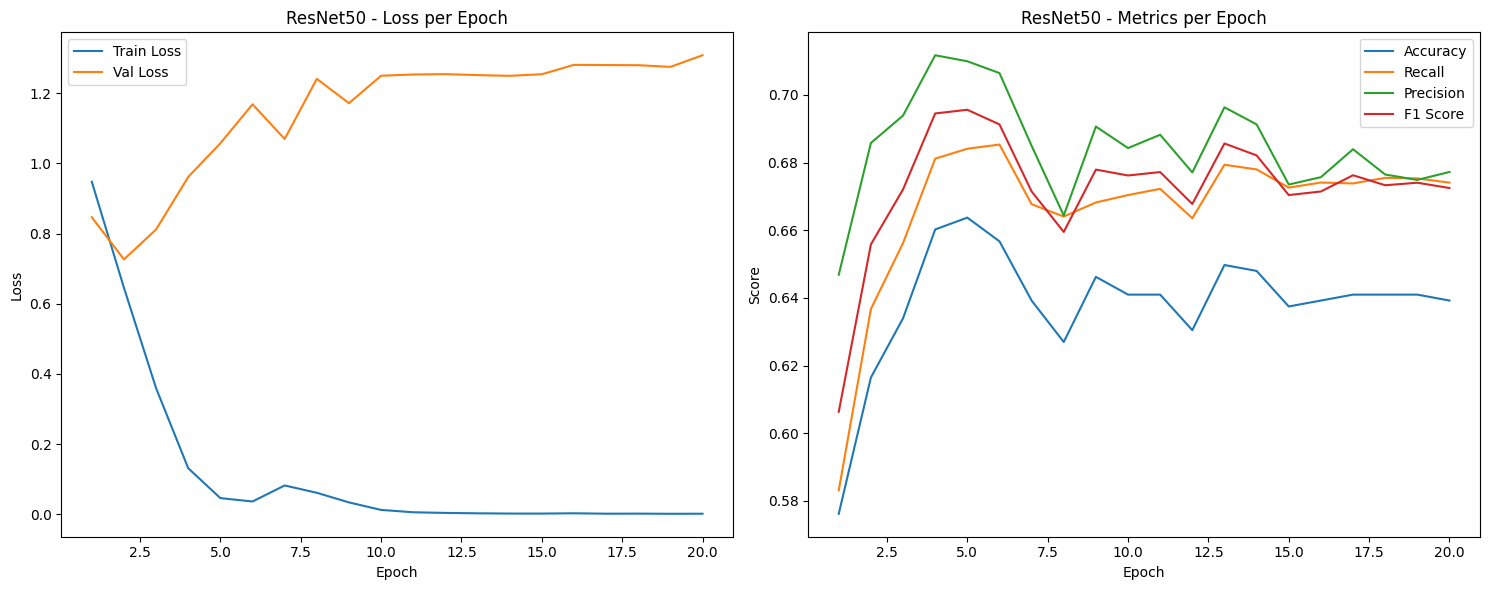

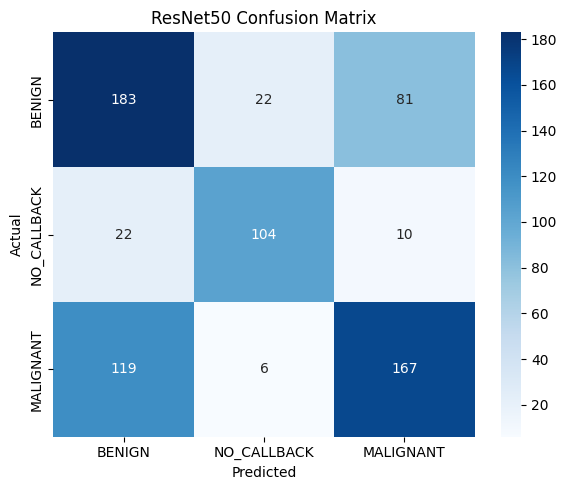


==== Training EfficientNetB0 ====

Epoch 1/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.9652 | Val Loss: 0.9095 | Val Acc: 0.59% | Recall: 0.6086 | Precision: 0.6156 | F1: 0.6104

Epoch 2/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.7641 | Val Loss: 0.7481 | Val Acc: 0.61% | Recall: 0.6217 | Precision: 0.6501 | F1: 0.6340

Epoch 3/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.6312 | Val Loss: 0.7144 | Val Acc: 0.62% | Recall: 0.6400 | Precision: 0.6747 | F1: 0.6542

Epoch 4/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.5242 | Val Loss: 0.6865 | Val Acc: 0.65% | Recall: 0.6716 | Precision: 0.7089 | F1: 0.6816

Epoch 5/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.4112 | Val Loss: 0.6928 | Val Acc: 0.66% | Recall: 0.6846 | Precision: 0.7051 | F1: 0.6924

Epoch 6/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3054 | Val Loss: 0.7380 | Val Acc: 0.68% | Recall: 0.6987 | Precision: 0.7240 | F1: 0.7093

Epoch 7/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.2077 | Val Loss: 0.7834 | Val Acc: 0.68% | Recall: 0.6992 | Precision: 0.7137 | F1: 0.7046

Epoch 8/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1600 | Val Loss: 0.8052 | Val Acc: 0.66% | Recall: 0.6892 | Precision: 0.7073 | F1: 0.6967

Epoch 9/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1189 | Val Loss: 0.8516 | Val Acc: 0.67% | Recall: 0.6881 | Precision: 0.7184 | F1: 0.7007

Epoch 10/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.0953 | Val Loss: 0.9491 | Val Acc: 0.68% | Recall: 0.7010 | Precision: 0.7057 | F1: 0.7007

Epoch 11/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.0801 | Val Loss: 0.8951 | Val Acc: 0.70% | Recall: 0.7165 | Precision: 0.7293 | F1: 0.7211

Epoch 12/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.0753 | Val Loss: 0.9363 | Val Acc: 0.69% | Recall: 0.7153 | Precision: 0.7208 | F1: 0.7169

Epoch 13/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.0633 | Val Loss: 0.9382 | Val Acc: 0.70% | Recall: 0.7151 | Precision: 0.7210 | F1: 0.7175

Epoch 14/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.0650 | Val Loss: 0.9622 | Val Acc: 0.69% | Recall: 0.7079 | Precision: 0.7180 | F1: 0.7107

Epoch 15/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.0596 | Val Loss: 0.9028 | Val Acc: 0.70% | Recall: 0.7209 | Precision: 0.7231 | F1: 0.7218

Epoch 16/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.0405 | Val Loss: 0.9378 | Val Acc: 0.70% | Recall: 0.7239 | Precision: 0.7262 | F1: 0.7247

Epoch 17/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.0445 | Val Loss: 0.9527 | Val Acc: 0.70% | Recall: 0.7180 | Precision: 0.7275 | F1: 0.7219

Epoch 18/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.0379 | Val Loss: 0.9790 | Val Acc: 0.69% | Recall: 0.7138 | Precision: 0.7184 | F1: 0.7155

Epoch 19/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.0315 | Val Loss: 0.9806 | Val Acc: 0.69% | Recall: 0.7155 | Precision: 0.7179 | F1: 0.7154

Epoch 20/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.0376 | Val Loss: 0.9990 | Val Acc: 0.69% | Recall: 0.7090 | Precision: 0.7159 | F1: 0.7122
Best model saved to: D:\TFM\breast_cancer_detection\models\output\efficientnetb0_22c065b7-5c4a-4eef-b70a-22ec119ecf59.pth (val_acc: 0.72%)
Model loaded from: D:\TFM\breast_cancer_detection\models\output\efficientnetb0_22c065b7-5c4a-4eef-b70a-22ec119ecf59.pth


Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Training history saved to D:\TFM\breast_cancer_detection\models\logs\efficientnetb0_22c065b7-5c4a-4eef-b70a-22ec119ecf59_history.csv


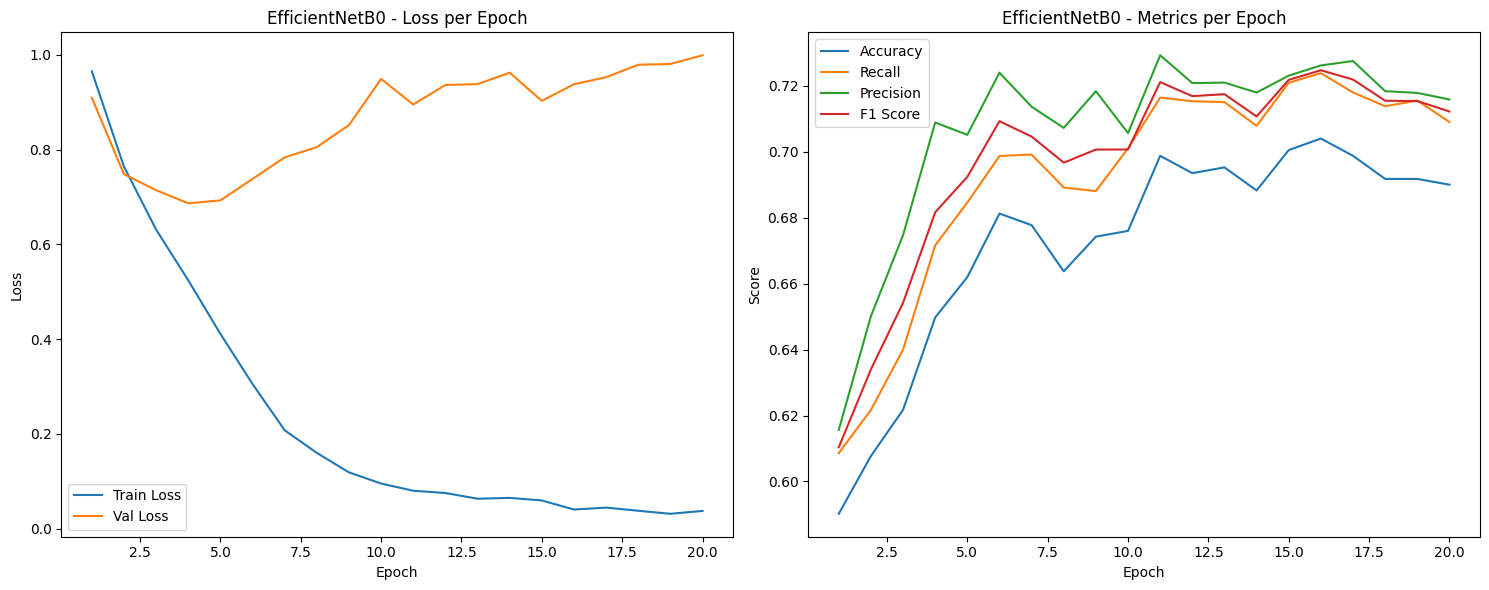

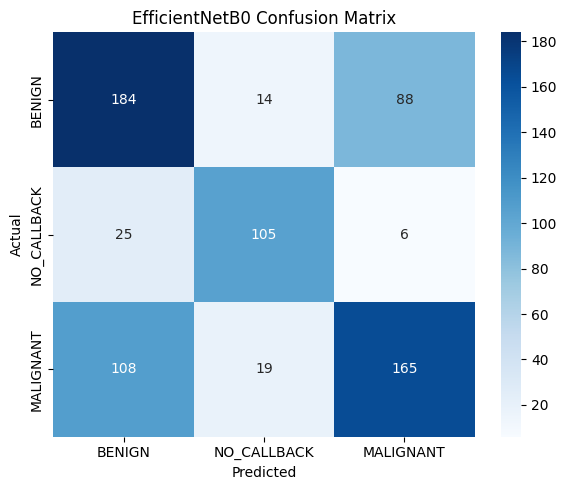


==== Training MobileNetV3 ====

Epoch 1/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.9792 | Val Loss: 1.0483 | Val Acc: 0.43% | Recall: 0.4795 | Precision: 0.4294 | F1: 0.4274

Epoch 2/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.8116 | Val Loss: 0.9814 | Val Acc: 0.49% | Recall: 0.5281 | Precision: 0.4834 | F1: 0.4871

Epoch 3/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.7144 | Val Loss: 0.9246 | Val Acc: 0.50% | Recall: 0.5558 | Precision: 0.4962 | F1: 0.5037

Epoch 4/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.6299 | Val Loss: 0.8957 | Val Acc: 0.49% | Recall: 0.5550 | Precision: 0.4927 | F1: 0.4982

Epoch 5/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.5547 | Val Loss: 0.8853 | Val Acc: 0.51% | Recall: 0.5753 | Precision: 0.5036 | F1: 0.5020

Epoch 6/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.4794 | Val Loss: 0.8933 | Val Acc: 0.51% | Recall: 0.5773 | Precision: 0.5073 | F1: 0.5119

Epoch 7/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.4085 | Val Loss: 0.8886 | Val Acc: 0.55% | Recall: 0.6122 | Precision: 0.5455 | F1: 0.5513

Epoch 8/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3333 | Val Loss: 0.9181 | Val Acc: 0.56% | Recall: 0.6286 | Precision: 0.5659 | F1: 0.5550

Epoch 9/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.2699 | Val Loss: 0.8973 | Val Acc: 0.57% | Recall: 0.6213 | Precision: 0.5680 | F1: 0.5645

Epoch 10/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1892 | Val Loss: 0.8869 | Val Acc: 0.59% | Recall: 0.6438 | Precision: 0.5868 | F1: 0.5881

Epoch 11/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1513 | Val Loss: 0.9143 | Val Acc: 0.59% | Recall: 0.6242 | Precision: 0.6132 | F1: 0.6048

Epoch 12/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1076 | Val Loss: 0.9393 | Val Acc: 0.58% | Recall: 0.6262 | Precision: 0.6086 | F1: 0.6061

Epoch 13/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.0861 | Val Loss: 0.9769 | Val Acc: 0.60% | Recall: 0.6344 | Precision: 0.6223 | F1: 0.6172

Epoch 14/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.0654 | Val Loss: 1.0209 | Val Acc: 0.61% | Recall: 0.6408 | Precision: 0.6250 | F1: 0.6296

Epoch 15/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.0373 | Val Loss: 1.1086 | Val Acc: 0.59% | Recall: 0.6309 | Precision: 0.6159 | F1: 0.6204

Epoch 16/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.0367 | Val Loss: 1.1729 | Val Acc: 0.62% | Recall: 0.6463 | Precision: 0.6354 | F1: 0.6390

Epoch 17/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.0382 | Val Loss: 1.2957 | Val Acc: 0.61% | Recall: 0.6457 | Precision: 0.6159 | F1: 0.6277

Epoch 18/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.0267 | Val Loss: 1.3602 | Val Acc: 0.61% | Recall: 0.6395 | Precision: 0.6341 | F1: 0.6359

Epoch 19/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.0267 | Val Loss: 1.3678 | Val Acc: 0.63% | Recall: 0.6532 | Precision: 0.6658 | F1: 0.6584

Epoch 20/20


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.0281 | Val Loss: 1.5097 | Val Acc: 0.61% | Recall: 0.6364 | Precision: 0.6318 | F1: 0.6341
Best model saved to: D:\TFM\breast_cancer_detection\models\output\mobilenetv3_22c065b7-5c4a-4eef-b70a-22ec119ecf59.pth (val_acc: 0.65%)
Model loaded from: D:\TFM\breast_cancer_detection\models\output\mobilenetv3_22c065b7-5c4a-4eef-b70a-22ec119ecf59.pth


Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Training history saved to D:\TFM\breast_cancer_detection\models\logs\mobilenetv3_22c065b7-5c4a-4eef-b70a-22ec119ecf59_history.csv


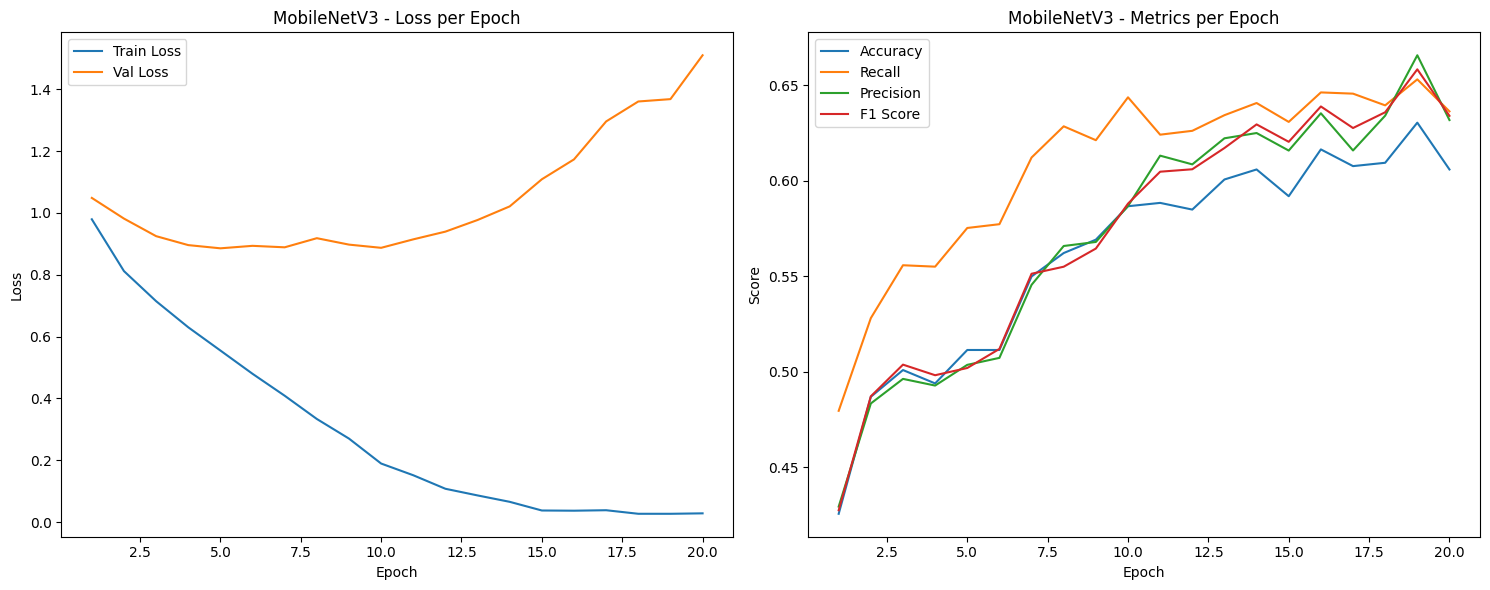

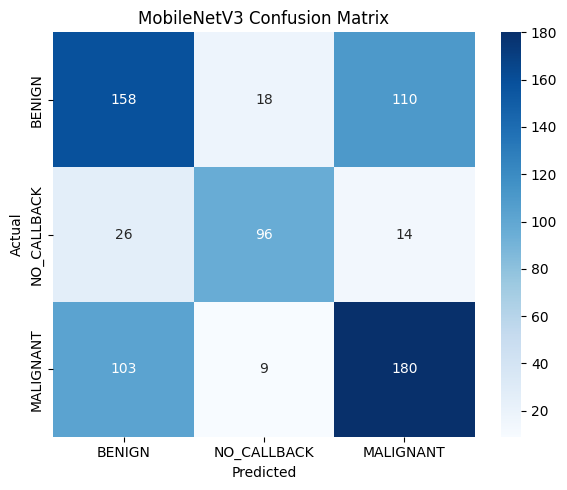

In [41]:
import datetime
from sklearn.metrics import confusion_matrix
from utils.visualization import (
    plot_training_history,
    save_training_history_to_csv,
    plot_confusion_matrix
)

results = []

strategies = {
    "ResNet50": ResNetModel(),
    "EfficientNetB0": EfficientNetModel(),
    "MobileNetV3": MobileNetModel(),
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for model_name, strategy in strategies.items():
    print(f"\n==== Training {model_name} ====")

    transform = strategy.get_transforms()

    train_dataset = CBISDDSMDataset("train.parquet", transform=transform)
    val_dataset   = CBISDDSMDataset("val.parquet", transform=transform)
    test_dataset  = CBISDDSMDataset("test.parquet", transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=70, shuffle=True, num_workers=4, pin_memory=True)
    val_loader   = DataLoader(val_dataset, batch_size=70, shuffle=False, num_workers=4, pin_memory=True)
    test_loader  = DataLoader(test_dataset, batch_size=70, shuffle=False, num_workers=4, pin_memory=True)

    model = strategy.get_model().to(device)
    optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=3)
    criterion = nn.CrossEntropyLoss()

    trainer = Trainer(model, device, optimizer, criterion, scheduler)
    trainer.fit(train_loader, val_loader, epochs=20)

    # Save best model
    model_path = os.path.join(MODELS_OUTPUT_PATH, f"{model_name.lower()}_{correlation_id}.pth")
    trainer.save_best_model(model_path)

    # Evaluate on test set
    trainer.load_model(model_path)
    acc, loss, recall, precision, f1 = trainer.evaluate(test_loader)

    # Save evaluation results
    results.append({
        "model": model_name,
        "accuracy": acc,
        "recall": recall,
        "precision": precision,
        "f1_score": f1
    })

    # Save training history
    history_path = os.path.join(MODELS_LOGS_OUTPUT_PATH, f"{model_name.lower()}_{correlation_id}_history.csv")
    save_training_history_to_csv(trainer.get_history(), history_path)

    # Plot training curves
    plot_training_history(trainer.get_history(), model_name=model_name)

    # Plot confusion matrix
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.numpy())

    plot_confusion_matrix(y_true, y_pred, class_names=["BENIGN", "NO_CALLBACK", "MALIGNANT"],
                          title=f"{model_name} Confusion Matrix")


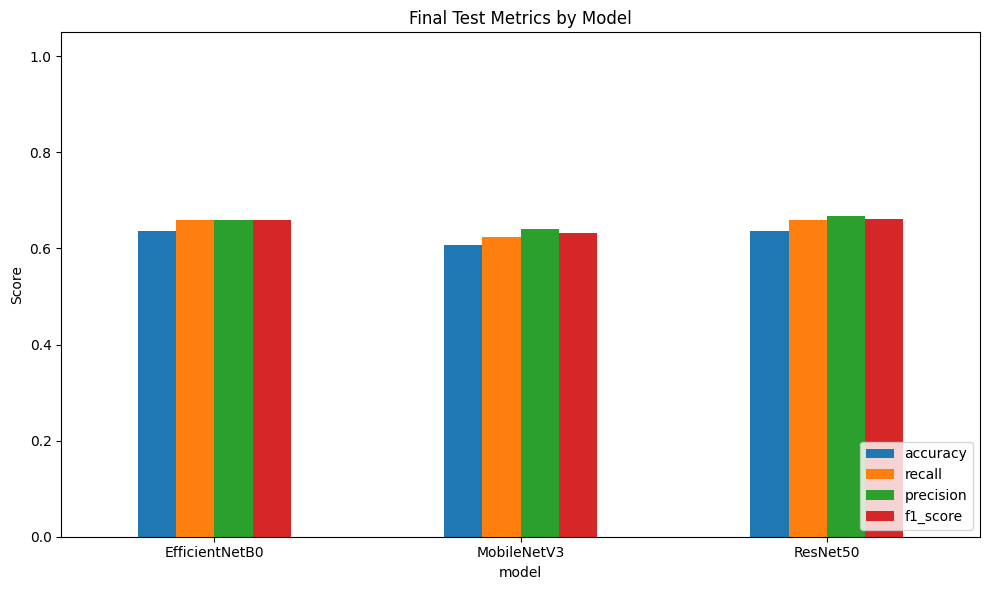

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torch.utils.data import DataLoader

# Convert results to DataFrame
results_df = pd.DataFrame(results).set_index("model")
results_df.sort_index(inplace=True)

# Plot all metrics in grouped bars
results_df.plot(kind="bar", figsize=(10, 6))
plt.title("Final Test Metrics by Model")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0, 1.05)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Save results
results_path = os.path.join(MODELS_LOGS_OUTPUT_PATH, f"summary_test_results_{correlation_id}.csv")
results_df.to_csv(results_path)